In [1]:
import os
import re
import time
import pandas as pd
import multiprocessing as mp
import numpy as np
import dask.dataframe as dd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import torch.nn.functional as F
from torch import nn
import math
import matplotlib.pyplot as plt

from statistics import mean

import torch
from torch import optim

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset_S022Final.csv")

df.dtypes

Event                   int64
sendTime              float64
prev_event_time       float64
next_event_time       float64
Next_Current_diff     float64
Next_Pre_diff         float64
SNext_Current_diff    float64
SNext_Pre_diff        float64
sender                 object
reciever               object
packetName             object
size                  float64
packet_type             int64
protocole              object
ip_src                 object
port_src                int64
ip_dest                object
port_dest               int64
Fragment                int64
offset                float64
Frequency              object
channel               float64
duration(ms)          float64
DataQueueLen          float64
droppedPKWrongPort    float64
DropPKByQueue         float64
passedUpPk            float64
rcvdPK                float64
rcvdPKFromHL          float64
rcvdPKFromLL          float64
sentDownPK            float64
sentPK                float64
snir                  float64
throughput

In [3]:
# Dropped sendTime, sender, reciever, IP_src, port_src, IP_dest, port_dest, Frequency
df=df[['Next_Current_diff','Next_Pre_diff','SNext_Current_diff','SNext_Pre_diff','rcvdPK','duration(ms)','packet_type','droppedPKWrongPort','sentPK','size','channel','DataQueueLen','passedUpPk','rcvdPKFromHL','rcvdPKFromLL','sentDownPK','DropPKByQueue','snir','throughput','label']]
# One hot encoding label
df = pd.get_dummies(df, columns = ['label'])
df.describe()

,Next_Current_diff,Next_Pre_diff,SNext_Current_diff,SNext_Pre_diff,rcvdPK,duration(ms),packet_type,droppedPKWrongPort,sentPK,size,...,rcvdPKFromHL,rcvdPKFromLL,sentDownPK,DropPKByQueue,snir,throughput,label_BROUILLAGE_Trafic,label_DDOS_UDP_FLOOD,label_Normal,label_PLUIES_ET_ORAGES
count,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,...,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000,513091.000000
mean,0.003985,0.007901,0.000125,0.000144,0.143150,0.177781,0.432781,0.178087,0.050519,0.217887,...,0.253119,0.101502,0.251047,0.008995,0.569399,0.131281,0.025797,0.231292,0.594536,0.148375
std,0.015314,0.022298,0.002855,0.006538,0.167985,0.346787,0.495461,0.153723,0.114416,0.377907,...,0.298685,0.294115,0.245451,0.048543,0.194192,0.198422,0.158528,0.421659,0.490982,0.355472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000576,0.002160,0.000003,0.000003,0.073569,0.011905,0.000000,0.039425,0.001931,0.001815,...,0.032938,0.000425,0.058985,0.000000,0.375298,0.011241,0.000000,0.000000,0.000000,0.000000
50%,0.001732,0.003547,0.000006,0.000005,0.089895,0.023810,0.000000,0.169153,0.002348,0.003630,...,0.052974,0.001245,0.106954,0.000000,0.578251,0.012920,0.000000,0.000000,1.000000,0.000000
75%,0.003432,0.007213,0.000016,0.000014,0.101881,0.035714,1.000000,0.261321,0.108578,0.102440,...,0.617303,0.008814,0.481451,0.000000,0.675468,0.377023,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.dtypes

Next_Current_diff          float64
Next_Pre_diff              float64
SNext_Current_diff         float64
SNext_Pre_diff             float64
rcvdPK                     float64
duration(ms)               float64
packet_type                  int64
droppedPKWrongPort         float64
sentPK                     float64
size                       float64
channel                    float64
DataQueueLen               float64
passedUpPk                 float64
rcvdPKFromHL               float64
rcvdPKFromLL               float64
sentDownPK                 float64
DropPKByQueue              float64
snir                       float64
throughput                 float64
label_BROUILLAGE_Trafic      uint8
label_DDOS_UDP_FLOOD         uint8
label_Normal                 uint8
label_PLUIES_ET_ORAGES       uint8
dtype: object

In [5]:
df.corr()

,Next_Current_diff,Next_Pre_diff,SNext_Current_diff,SNext_Pre_diff,rcvdPK,duration(ms),packet_type,droppedPKWrongPort,sentPK,size,...,rcvdPKFromHL,rcvdPKFromLL,sentDownPK,DropPKByQueue,snir,throughput,label_BROUILLAGE_Trafic,label_DDOS_UDP_FLOOD,label_Normal,label_PLUIES_ET_ORAGES
Next_Current_diff,1.000000,0.734314,0.003023,-0.001697,0.068768,-0.072639,0.088377,0.002017,-0.053612,-0.086537,...,-0.078064,0.049065,-0.075790,-0.029295,0.024772,-0.098907,0.011390,-0.089203,0.086481,-0.018717
Next_Pre_diff,0.734314,1.000000,0.032502,0.009414,0.093805,-0.092580,0.043940,0.003713,-0.072763,-0.117806,...,-0.105205,0.066826,-0.102776,-0.040145,0.033732,-0.134629,0.019610,-0.121537,0.117285,-0.026574
SNext_Current_diff,0.003023,0.032502,1.000000,0.172924,0.022319,-0.015697,0.007786,0.004921,-0.009079,-0.018605,...,-0.012364,0.009109,-0.011585,-0.004173,0.005860,-0.016866,0.006968,-0.019644,0.011546,0.004247
SNext_Pre_diff,-0.001697,0.009414,0.172924,1.000000,0.004981,-0.006837,0.002572,-0.006907,-0.005751,-0.009390,...,-0.008187,-0.000237,-0.007427,-0.002874,-0.008860,-0.010237,0.001156,-0.010345,0.007230,0.001771
rcvdPK,0.068768,0.093805,0.022319,0.004981,1.000000,-0.190288,0.078653,-0.055416,-0.173171,-0.262702,...,-0.276760,-0.098514,-0.170759,-0.104262,-0.021332,-0.327417,-0.046455,-0.307310,0.368394,-0.123584
duration(ms),-0.072639,-0.092580,-0.015697,-0.006837,-0.190288,1.000000,-0.417812,0.281991,0.427723,0.784631,...,0.682600,-0.141204,0.717680,0.236614,0.239419,0.700568,-0.075527,0.785464,-0.511255,-0.191880
packet_type,0.088377,0.043940,0.007786,0.002572,0.078653,-0.417812,1.000000,-0.090875,-0.134563,-0.231552,...,-0.214045,0.041611,-0.230683,-0.084623,-0.073689,-0.220468,0.063168,-0.230248,0.136704,0.056131
droppedPKWrongPort,0.002017,0.003713,0.004921,-0.006907,-0.055416,0.281991,-0.090875,1.000000,0.502897,0.356235,...,0.436205,0.414488,0.439385,0.121444,0.708192,0.382180,0.197040,0.357039,-0.130801,-0.330727
sentPK,-0.053612,-0.072763,-0.009079,-0.005751,-0.173171,0.427723,-0.134563,0.502897,1.000000,0.541007,...,0.613147,-0.114936,0.572914,0.153423,0.225588,0.574729,-0.069026,0.544399,-0.316964,-0.177187
size,-0.086537,-0.117806,-0.018605,-0.009390,-0.262702,0.784631,-0.231552,0.356235,0.541007,1.000000,...,0.867087,-0.175031,0.870490,0.286011,0.301618,0.888883,-0.092751,0.995511,-0.652709,-0.237977


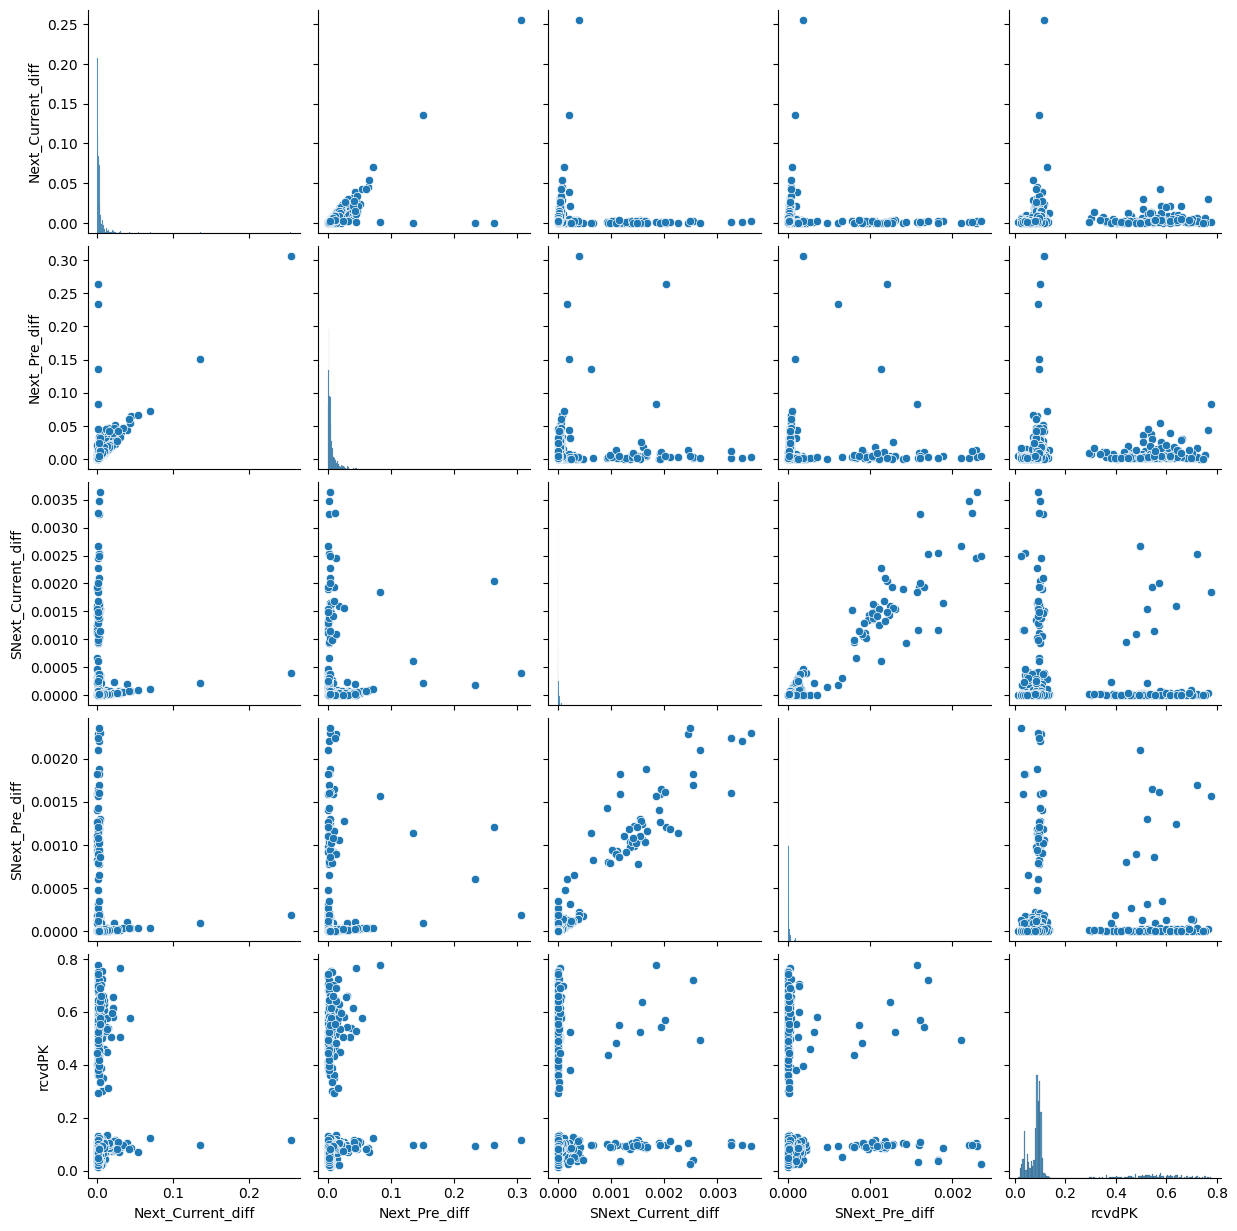

In [6]:
import seaborn as sns
sample = df.sample(n=1000, random_state=1)
sns.pairplot(sample[['Next_Current_diff','Next_Pre_diff','SNext_Current_diff','SNext_Pre_diff','rcvdPK']])

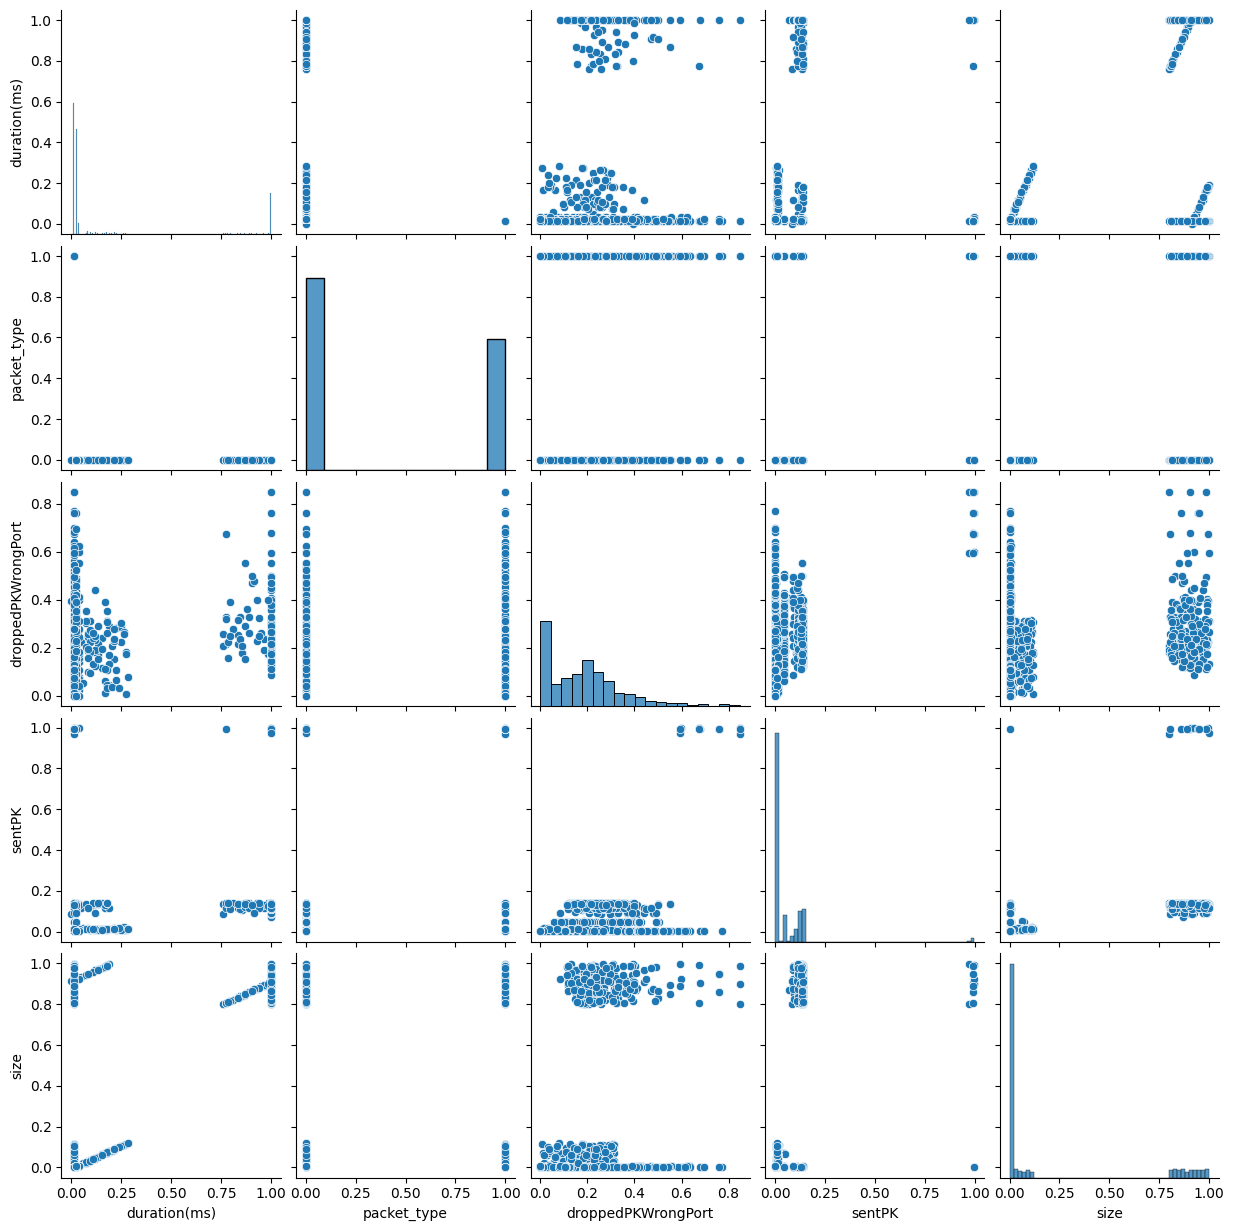

In [7]:
sns.pairplot(sample[['duration(ms)','packet_type','droppedPKWrongPort','sentPK','size']])

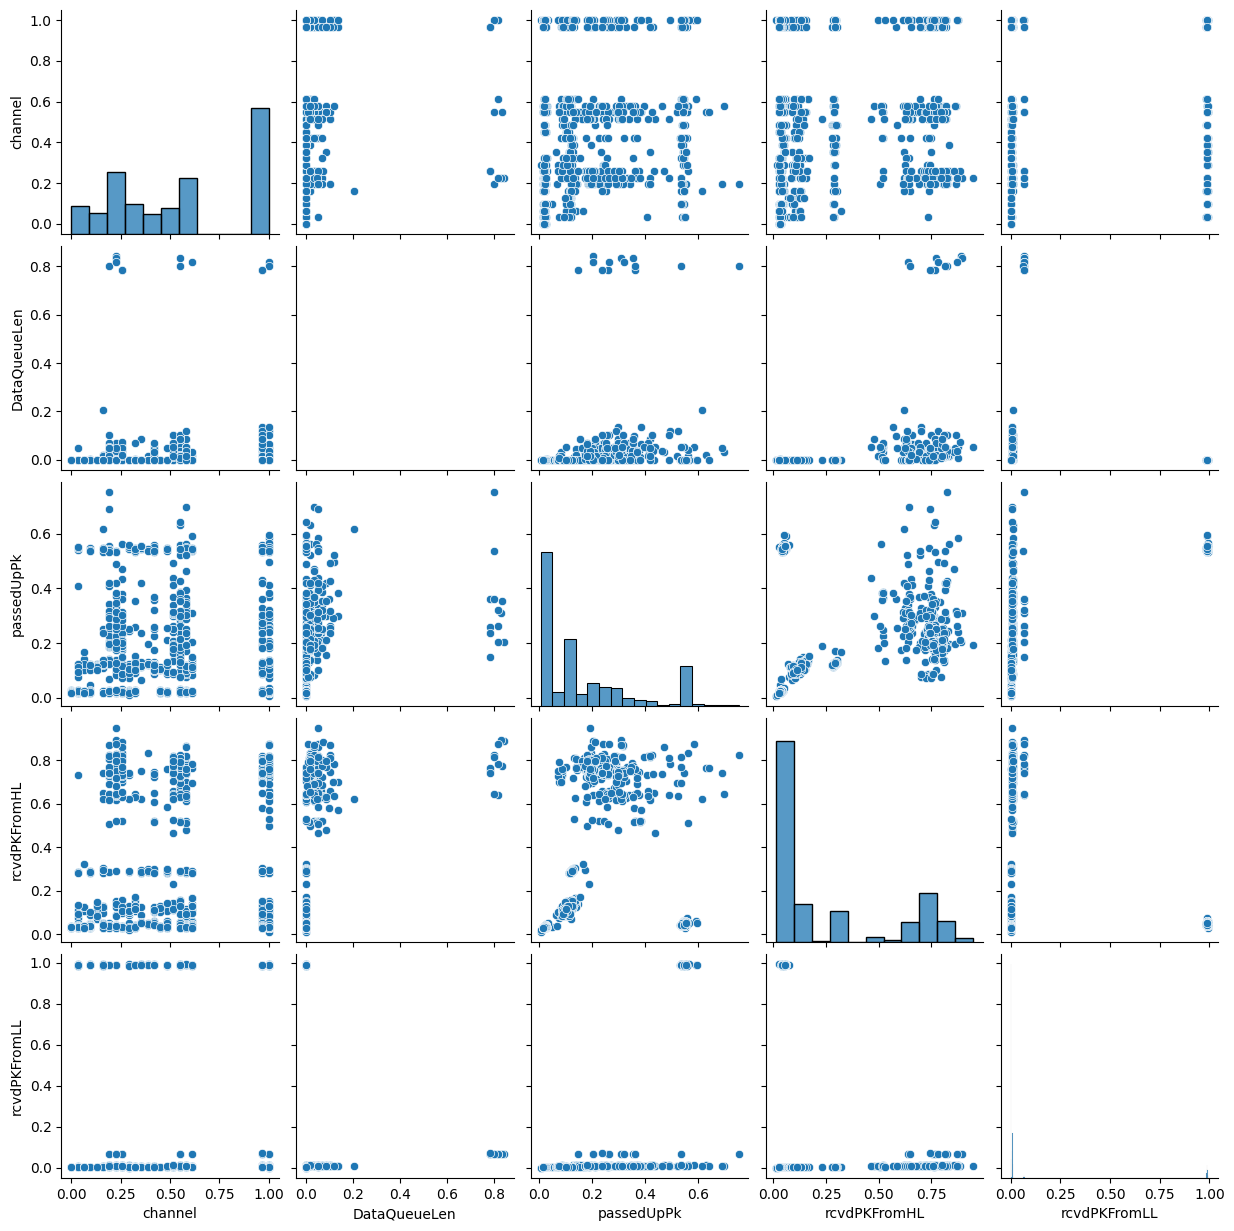

In [8]:
sns.pairplot(sample[['channel','DataQueueLen','passedUpPk','rcvdPKFromHL','rcvdPKFromLL']])

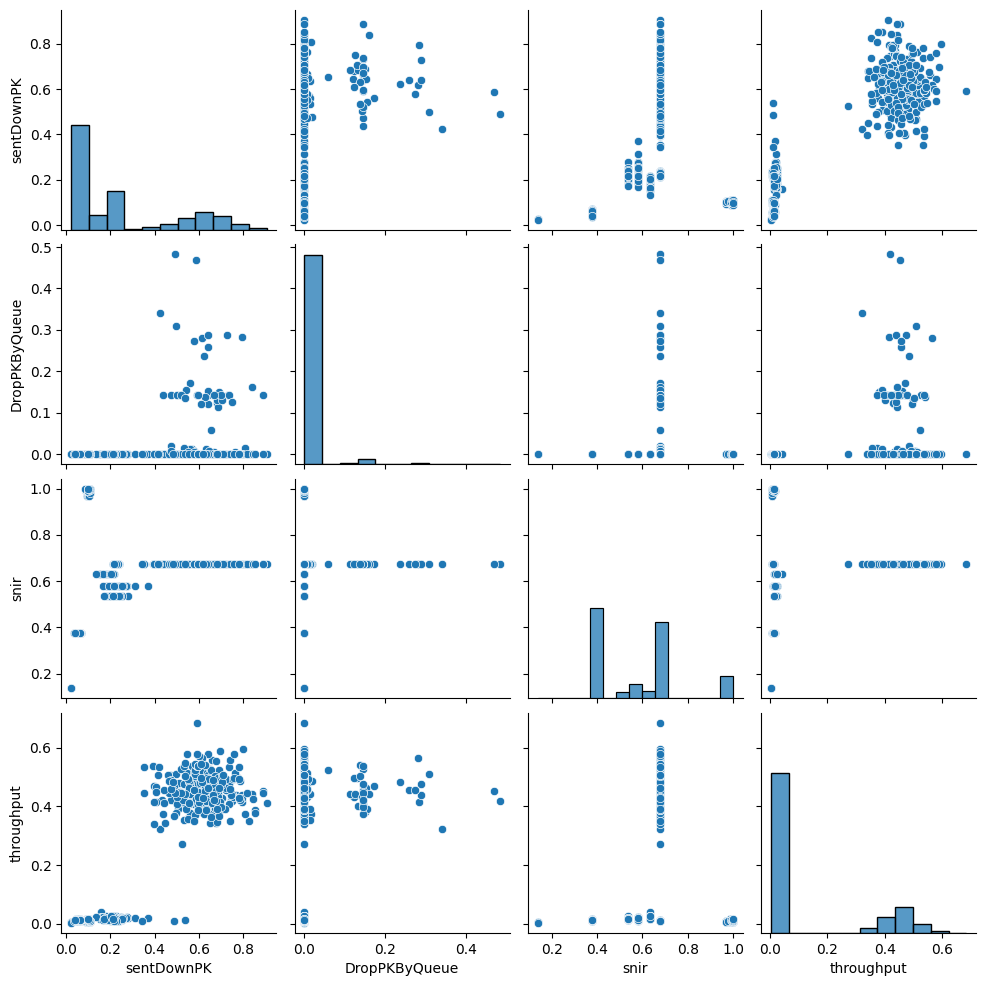

In [9]:
sns.pairplot(sample[['sentDownPK','DropPKByQueue','snir','throughput']])

<Axes: >

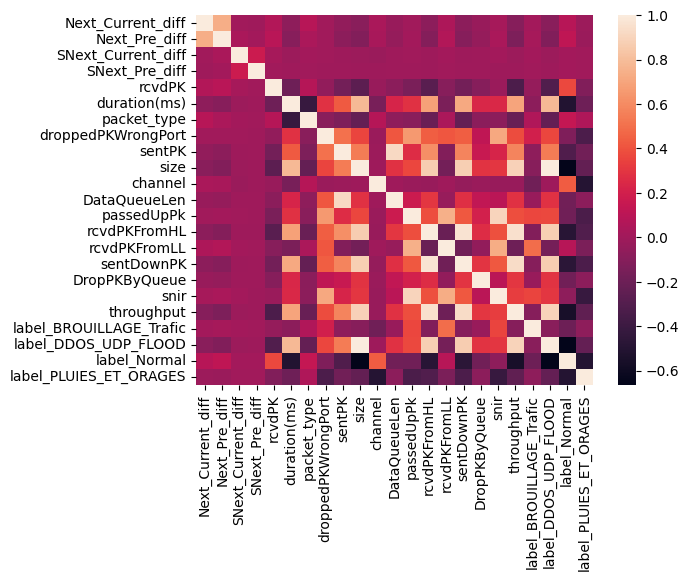

In [10]:
sns.heatmap(df.corr())

In [11]:
import tensorflow as tf

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters = 32, kernel_size = 3, activation='relu', input_shape=(19, 1)))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(4))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 32)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 16836 (65.77 KB)
Trainable params: 16836 (65.77 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

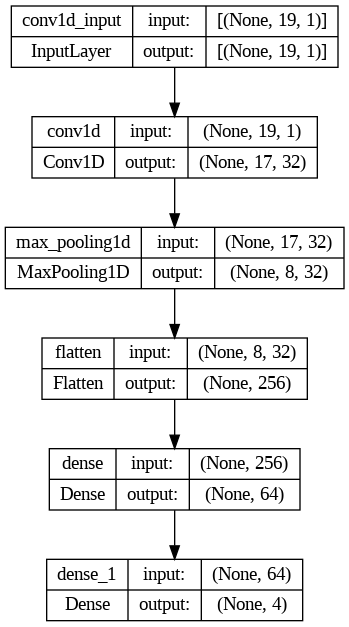

In [13]:
tf.keras.utils.plot_model(model, to_file="cnn_model.png", show_shapes=True)

In [14]:
X = df.drop(columns = ['label_BROUILLAGE_Trafic','label_DDOS_UDP_FLOOD','label_Normal','label_PLUIES_ET_ORAGES'])
y = df[['label_BROUILLAGE_Trafic','label_DDOS_UDP_FLOOD','label_Normal','label_PLUIES_ET_ORAGES']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    validation_data=(X_valid, y_valid)
                    )

Epoch 1/5
10262/10262 [==============================] - 63s 5ms/step - loss: 0.0222 - accuracy: 0.9932 - val_loss: 0.0027 - val_accuracy: 0.9998
Epoch 2/5
10262/10262 [==============================] - 48s 5ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 8.1612e-04 - val_accuracy: 0.9999
Epoch 3/5
10262/10262 [==============================] - 51s 5ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 5.7601e-04 - val_accuracy: 0.9999
Epoch 4/5
10262/10262 [==============================] - 51s 5ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 3.8298e-04 - val_accuracy: 0.9999
Epoch 5/5
10262/10262 [==============================] - 45s 4ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 4.6569e-04 - val_accuracy: 0.9999


In [17]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

3207/3207 [==============================] - 10s 3ms/step - loss: 4.8184e-04 - accuracy: 0.9999


In [18]:
model.save('CNN_Classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
from sklearn.metrics import classification_report
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CNN_Classification.h5')
y_predict = model.predict(X_test)
y_predict = (y_predict > 0.5)
print(classification_report(y_test, y_predict, target_names =['label_BROUILLAGE_Trafic','label_DDOS_UDP_FLOOD','label_Normal','label_PLUIES_ET_ORAGES']))

3207/3207 [==============================] - 7s 2ms/step
                         precision    recall  f1-score   support

label_BROUILLAGE_Trafic       1.00      1.00      1.00      2572
   label_DDOS_UDP_FLOOD       0.32      1.00      0.48     23639
           label_Normal       0.71      0.97      0.82     60965
 label_PLUIES_ET_ORAGES       1.00      1.00      1.00     15443

              micro avg       0.58      0.98      0.73    102619
              macro avg       0.76      0.99      0.83    102619
           weighted avg       0.67      0.98      0.78    102619
            samples avg       0.62      0.98      0.74    102619



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
